# Demonstration of mermaid's simple registration interface

In [15]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt

import mermaid.simple_interface as SI
import mermaid.example_generation as EG
import mermaid.module_parameters as pars
import mermaid.similarity_measure_factory as sim

import random as rn
import copy, json

First, we create an empty parameter dictionary ....

In [17]:
params = pars.ParameterDict()
params.write_JSON('step_by_step_example_data.json')
params.write_JSON_comments('step_by_step_example_data_with_comments.json')

Writing parameter file = step_by_step_example_data.json
Writing parameter file = step_by_step_example_data_with_comments.json


Next, we create a synthetic image pair in 2D to register. We will also be adding noise to the background of these images.

In [129]:
use_synthetic_test_case = True
add_noise_to_bg = True
dim = 2
sz = 64

szEx = np.tile(sz, dim)
I, T, spacing = EG.CreateSquares(dim, add_noise_to_bg).create_image_pair(szEx, params) 
mask = copy.copy(I)

x1 = 32
x2 = 32
r = 300

y1 = 7
y2 = 9
a = 5
b = 2.5
r2 = 6
c = 20

# Make square
for i in range(I[0,0,:,:].shape[0]):
    for j in range(I[0,0,:,:].shape[1]):
        if   i > x1 - c and i < x1 + c and j > x2 - c and j < x2 + c:
            I[0,0,i,j] = 0.8 + rn.uniform(0,0.01)


# make template
for i in range(T[0,0,:,:].shape[0]):
    for j in range(T[0,0,:,:].shape[1]):
        if (i-x1)**2 + (j-x2)**2 > r:
            T[0,0,i,j] = 0 + rn.uniform(0,0.15)
        else:
            T[0,0,i,j] = 0.8 + rn.uniform(0,0.01)

# add lesion
I_no_lesion = copy.copy(I)
for i in range(I[0,0,:,:].shape[0]):
    for j in range(I[0,0,:,:].shape[1]):
        if ((i/a)-y1)**2 + ((j/b)-y2)**2 < r2:
            I[0,0,i,j] = .5 + rn.uniform(0,0.15)

# make mask
for i in range(mask[0,0,:,:].shape[0]):
    for j in range(mask[0,0,:,:].shape[1]):
        if ((i/a)-y1)**2 + ((j/b)-y2)**2 > r2:
            mask[0,0,i,j] = 1
        else:
            mask[0,0,i,j] = 0

### Make lesion prior

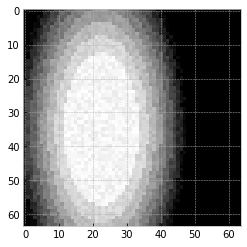

In [130]:
y1 = 7
y2 = 9
a = 5
b = 2.5
r2 = 100
p = 0

lesion_prior = 0*copy.copy(I)
while r2 > 10:
    #add lesion
    
    for i in range(lesion_prior[0,0,:,:].shape[0]):
        for j in range(lesion_prior[0,0,:,:].shape[1]):
            if ((i/a)-y1)**2 + ((j/b)-y2)**2 < r2:
                lesion_prior[0,0,i,j] = p + rn.uniform(0,0.15)
    r2-=10
    p+=0.2
    
lesion_prior = (1/lesion_prior.max())*lesion_prior
plt.imshow(lesion_prior[0,0,:,:],cmap='gray')

`I0` and `I1` effectively constitute a batch of size 1. Hence, the numpy array is of shape `1x1x64x64`.

Size I: (1, 1, 64, 64)
Size T: (1, 1, 64, 64)


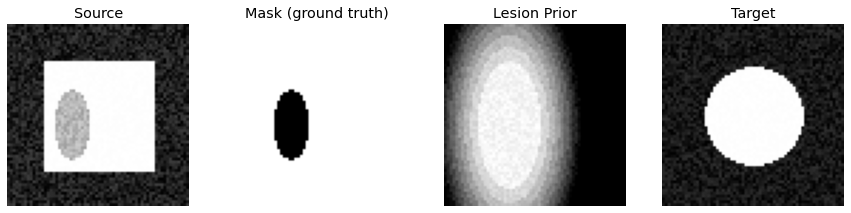

In [131]:
print('Size I:', I.shape)
print('Size T:', T.shape)
plt.figure(figsize=(15,5))
plt.subplot(141)
plt.imshow(I[0,0,:,:],cmap='gray')
plt.title('Source')
plt.axis('off');

plt.subplot(142)
plt.imshow(mask[0,0,:,:],cmap='gray')
plt.title('Mask (ground truth)')
plt.axis('off');

plt.subplot(143)
plt.imshow(lesion_prior[0,0,:,:],cmap='gray')
plt.title('Lesion Prior')
plt.axis('off');

plt.subplot(144)
plt.imshow(T[0,0,:,:],cmap='gray')
plt.title('Target')
plt.axis('off');

Alternatively, we can also create an example pair of realistic 2D MRI slices with spacing normalized to $[0,1]$. In that case, images are of size `1x1x128x128`.

In [132]:
def show_image(I, title):
    plt.imshow(I[0,0,:,:], cmap='gray')
    plt.axis('off')
    plt.title(title)

Next, we are ready to create an instance of `SI.RegisterImagePair` and show all available registration models to select from.

In [140]:
si = SI.RegisterImagePair()
si.print_available_models()


Known registration models are:
------------------------------
                              affine_map: map-based affine registration
                           diffusion_map: displacement-based diffusion registration
                           curvature_map: displacement-based curvature registration
                     total_variation_map: displacement-based total variation registration
                                 svf_map: map-based stationary velocity field
                               svf_image: image-based stationary velocity field
               svf_scalar_momentum_image: image-based stationary velocity field using the scalar momentum
                 svf_scalar_momentum_map: map-based stationary velocity field using the scalar momentum
               svf_vector_momentum_image: image-based stationary velocity field using the vector momentum
                 svf_vector_momentum_map: map-based stationary velocity field using the vector momentum
                      lddmm_s

That's basically it. We can now simply use the `register_images` method of `SI.RegisterImagePair` with appropriate parameters. 

In the following examples of different registration models, we will always keep track of all intermediate results by 
setting the `recording_step` to 1, i.e., we record the intermediate results in each optimization iteration and turn visualization off, as we will visualize the results later by hand. You can also set `recording_step` to `None` in which case nothing is recorded. 

Also, you can set `visualization_step` to a non-zero value which will produce an overview plot of the intermediate registration results at the given visualization steps.

# Registration


## Registration with mask

Loading parameter file = params.json
Overwriting key = use_map; category = root.model.deformation; value =  True -> True
Overwriting key = type; category = root.model.registration_model; value =  lddmm_shooting_map -> lddmm_shooting_map
Overwriting key = name; category = root.optimizer; value =  sgd -> sgd
Overwriting key = nr_of_iterations; category = root.optimizer.single_scale; value =  1 -> 50
Overwriting key = type; category = root.model.registration_model.similarity_measure; value =  ssd -> ssd
Overwriting key = rel_ftol; category = root.optimizer.single_scale; value =  0.0001 -> 1e-07
mapLowResFactor = 1: performing computations at original resolution.
Overwriting key = use_map; category = root.model.deformation; value =  True -> True
Overwriting key = map_low_res_factor; category = root.model.deformation; value =  1.0 -> 1.0
Creating new category: root.optimizer.multi_scale
Using default value = [1.0, 0.5, 0.25] for key = scale_factors of category = root.optimizer.multi_scale
U

<Figure size 432x288 with 0 Axes>

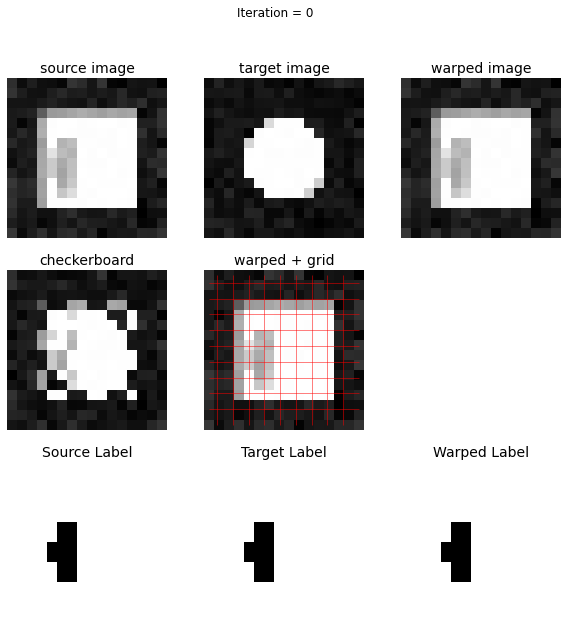

    1-Tot: E=005.8797 | simE=005.3711 | regE=000.5086 | optParE=000.0000 | relF=000.3177 | 
    1-Img: E=005.8797 | simE=005.3711 | regE=000.5086 |
    2-Tot: E=004.1821 | simE=003.5072 | regE=000.6749 | optParE=000.0000 | relF=000.3276 | 
    2-Img: E=004.1821 | simE=003.5072 | regE=000.6749 |
    3-Tot: E=003.6066 | simE=002.7743 | regE=000.8323 | optParE=000.0000 | relF=000.1249 | 
    3-Img: E=003.6066 | simE=002.7743 | regE=000.8323 |
    4-Tot: E=002.9964 | simE=002.0694 | regE=000.9270 | optParE=000.0000 | relF=000.1527 | 
    4-Img: E=002.9964 | simE=002.0694 | regE=000.9270 |
    5-Tot: E=002.4583 | simE=001.4549 | regE=001.0034 | optParE=000.0000 | relF=000.1556 | 
    5-Img: E=002.4583 | simE=001.4549 | regE=001.0034 |


<Figure size 432x288 with 0 Axes>

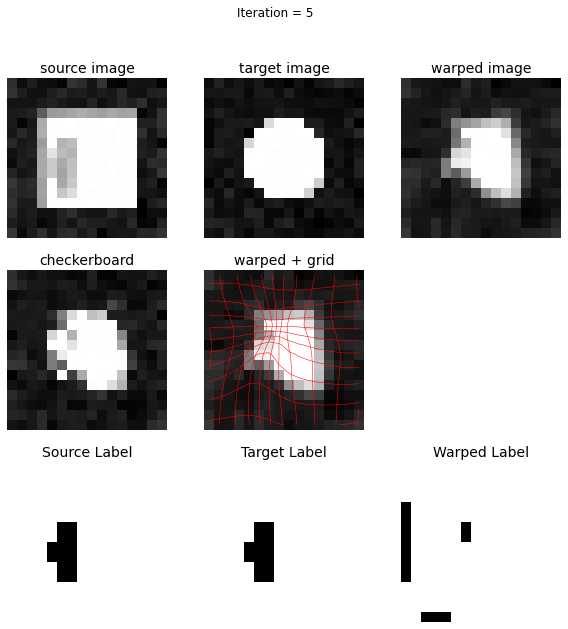

    6-Tot: E=002.1923 | simE=001.1053 | regE=001.0871 | optParE=000.0000 | relF=000.0833 | 
    6-Img: E=002.1923 | simE=001.1053 | regE=001.0871 |
    7-Tot: E=002.0369 | simE=000.8792 | regE=001.1576 | optParE=000.0000 | relF=000.0512 | 
    7-Img: E=002.0369 | simE=000.8792 | regE=001.1576 |
    8-Tot: E=002.0438 | simE=000.8495 | regE=001.1943 | optParE=000.0000 | relF=000.0023 | 
    8-Img: E=002.0438 | simE=000.8495 | regE=001.1943 |
    9-Tot: E=001.8971 | simE=000.7046 | regE=001.1925 | optParE=000.0000 | relF=000.0506 | 
    9-Img: E=001.8971 | simE=000.7046 | regE=001.1925 |
   10-Tot: E=001.7976 | simE=000.6248 | regE=001.1728 | optParE=000.0000 | relF=000.0356 | 
   10-Img: E=001.7976 | simE=000.6248 | regE=001.1728 |


<Figure size 432x288 with 0 Axes>

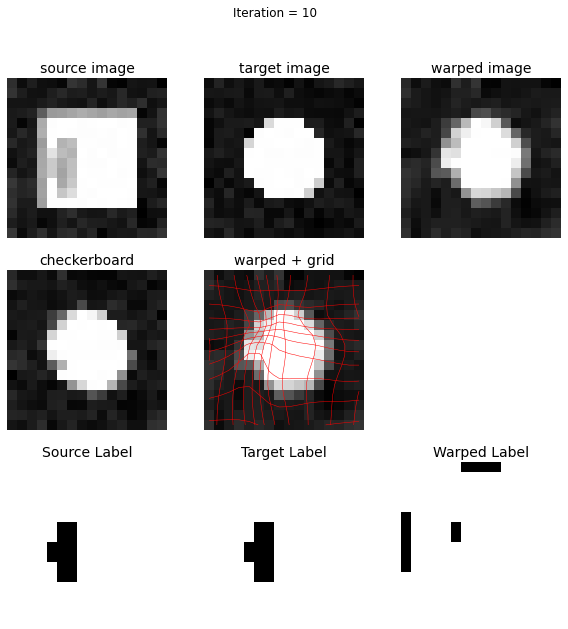

   11-Tot: E=001.6909 | simE=000.5849 | regE=001.1060 | optParE=000.0000 | relF=000.0396 | 
   11-Img: E=001.6909 | simE=000.5849 | regE=001.1060 |
   12-Tot: E=001.5677 | simE=000.5604 | regE=001.0072 | optParE=000.0000 | relF=000.0480 | 
   12-Img: E=001.5677 | simE=000.5604 | regE=001.0072 |
   13-Tot: E=001.4507 | simE=000.5519 | regE=000.8988 | optParE=000.0000 | relF=000.0477 | 
   13-Img: E=001.4507 | simE=000.5519 | regE=000.8988 |
   14-Tot: E=001.3447 | simE=000.5459 | regE=000.7988 | optParE=000.0000 | relF=000.0452 | 
   14-Img: E=001.3447 | simE=000.5459 | regE=000.7988 |
   15-Tot: E=001.2405 | simE=000.5303 | regE=000.7102 | optParE=000.0000 | relF=000.0465 | 
   15-Img: E=001.2405 | simE=000.5303 | regE=000.7102 |


<Figure size 432x288 with 0 Axes>

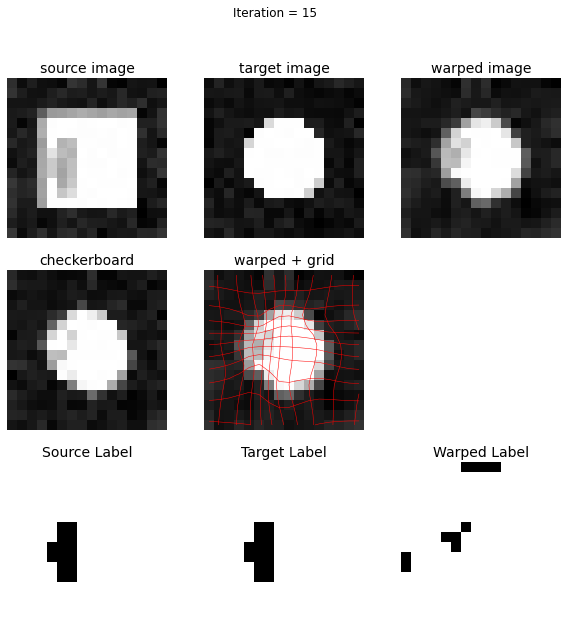

   16-Tot: E=001.1446 | simE=000.5108 | regE=000.6337 | optParE=000.0000 | relF=000.0447 | 
   16-Img: E=001.1446 | simE=000.5108 | regE=000.6337 |
   17-Tot: E=001.0584 | simE=000.4817 | regE=000.5767 | optParE=000.0000 | relF=000.0419 | 
   17-Img: E=001.0584 | simE=000.4817 | regE=000.5767 |
   18-Tot: E=000.9952 | simE=000.4630 | regE=000.5322 | optParE=000.0000 | relF=000.0317 | 
   18-Img: E=000.9952 | simE=000.4630 | regE=000.5322 |
   19-Tot: E=000.9447 | simE=000.4403 | regE=000.5044 | optParE=000.0000 | relF=000.0260 | 
   19-Img: E=000.9447 | simE=000.4403 | regE=000.5044 |


<Figure size 432x288 with 0 Axes>

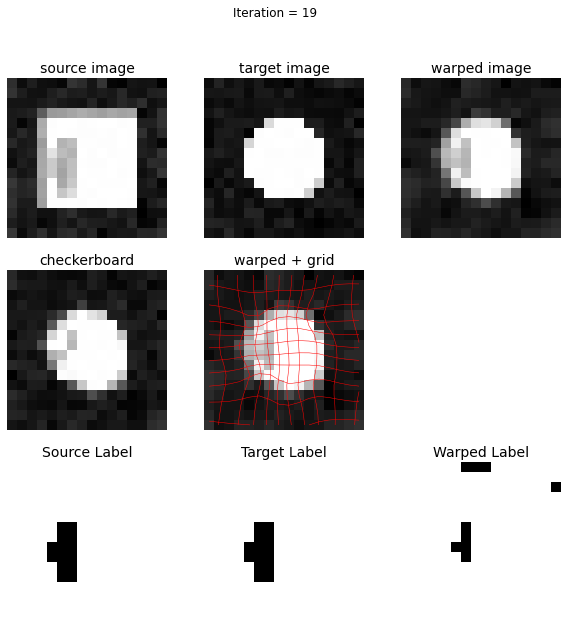

-->Elapsed time 17.13299[s]
Before
[ 1  1 32 32]
Optimizing for scale = 0.5
Overwriting key = use_map; category = root.model.deformation; value =  True -> True
Overwriting key = map_low_res_factor; category = root.model.deformation; value =  None -> None
Setting learning rate to None
Overwriting key = type; category = root.model.registration_model; value =  lddmm_shooting_map -> lddmm_shooting_map
Overwriting key = type; category = root.model.registration_model; value =  lddmm_shooting_map -> lddmm_shooting_map
Using map-based lddmm_shooting_map model
the param of smoother is <mermaid.smoother_factory.MultiGaussianFourierSmoother object at 0x1339d0790>
works in mermaid iter mode
LDDMMShootingVectorMomentumMapNet(
  (integrator): ODEWrapBlock()
)
Overwriting key = name; category = root.optimizer; value =  sgd -> sgd
Overwriting key = rel_ftol; category = root.optimizer.single_scale; value =  1e-07 -> 1e-07
Explicitly setting the optimization parameters
Optimizing for at most 20 iteratio

<Figure size 432x288 with 0 Axes>

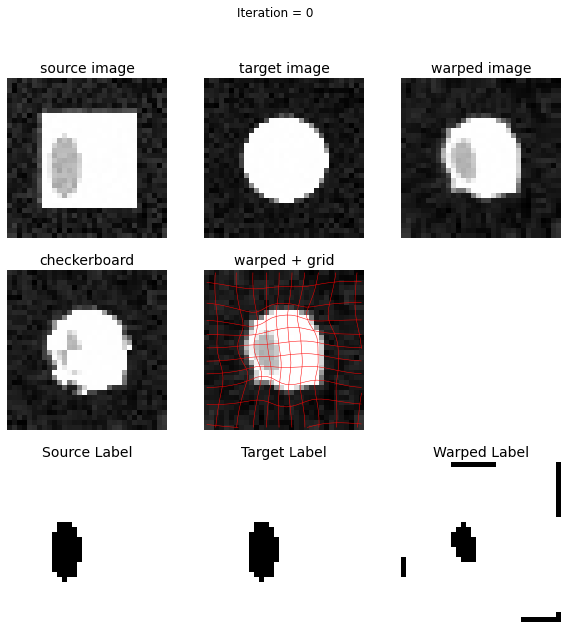

    1-Tot: E=001.1651 | simE=000.7701 | regE=000.3950 | optParE=000.0000 | relF=000.1103 | 
    1-Img: E=001.1651 | simE=000.7701 | regE=000.3950 |
    2-Tot: E=000.9002 | simE=000.5410 | regE=000.3592 | optParE=000.0000 | relF=000.1394 | 
    2-Img: E=000.9002 | simE=000.5410 | regE=000.3592 |
    3-Tot: E=000.8339 | simE=000.4985 | regE=000.3353 | optParE=000.0000 | relF=000.0362 | 
    3-Img: E=000.8339 | simE=000.4985 | regE=000.3353 |
    4-Tot: E=000.8364 | simE=000.5085 | regE=000.3279 | optParE=000.0000 | relF=000.0014 | 
    4-Img: E=000.8364 | simE=000.5085 | regE=000.3279 |
    5-Tot: E=000.8143 | simE=000.4815 | regE=000.3328 | optParE=000.0000 | relF=000.0122 | 
    5-Img: E=000.8143 | simE=000.4815 | regE=000.3328 |


<Figure size 432x288 with 0 Axes>

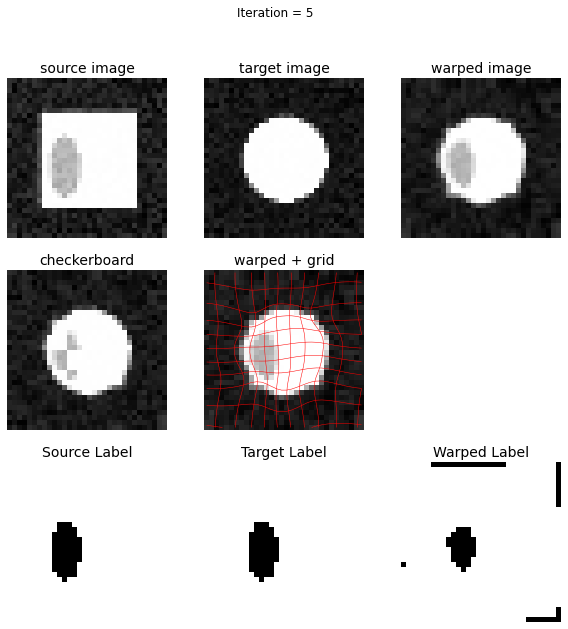

    6-Tot: E=000.7805 | simE=000.4378 | regE=000.3427 | optParE=000.0000 | relF=000.0190 | 
    6-Img: E=000.7805 | simE=000.4378 | regE=000.3427 |
    7-Tot: E=000.7444 | simE=000.3902 | regE=000.3542 | optParE=000.0000 | relF=000.0207 | 
    7-Img: E=000.7444 | simE=000.3902 | regE=000.3542 |
    8-Tot: E=000.7311 | simE=000.3690 | regE=000.3621 | optParE=000.0000 | relF=000.0077 | 
    8-Img: E=000.7311 | simE=000.3690 | regE=000.3621 |
    9-Tot: E=000.7145 | simE=000.3513 | regE=000.3632 | optParE=000.0000 | relF=000.0097 | 
    9-Img: E=000.7145 | simE=000.3513 | regE=000.3632 |
   10-Tot: E=000.6978 | simE=000.3372 | regE=000.3606 | optParE=000.0000 | relF=000.0098 | 
   10-Img: E=000.6978 | simE=000.3372 | regE=000.3606 |


<Figure size 432x288 with 0 Axes>

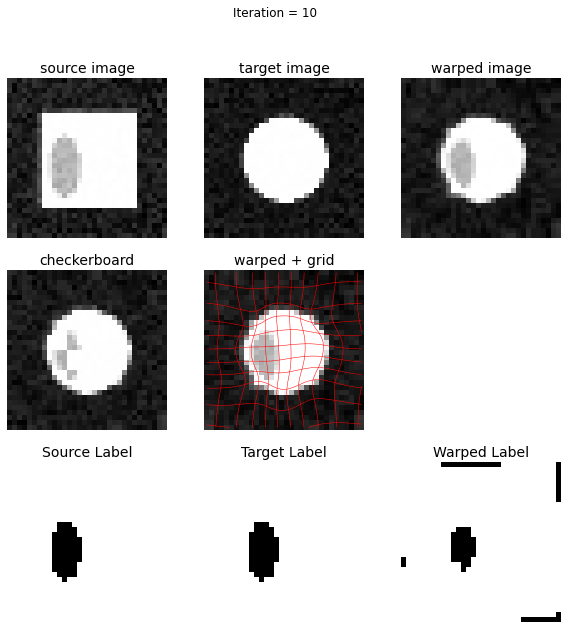

   11-Tot: E=000.6853 | simE=000.3285 | regE=000.3569 | optParE=000.0000 | relF=000.0074 | 
   11-Img: E=000.6853 | simE=000.3285 | regE=000.3569 |
   12-Tot: E=000.6768 | simE=000.3235 | regE=000.3532 | optParE=000.0000 | relF=000.0051 | 
   12-Img: E=000.6768 | simE=000.3235 | regE=000.3532 |
   13-Tot: E=000.6683 | simE=000.3175 | regE=000.3508 | optParE=000.0000 | relF=000.0051 | 
   13-Img: E=000.6683 | simE=000.3175 | regE=000.3508 |
   14-Tot: E=000.6587 | simE=000.3097 | regE=000.3490 | optParE=000.0000 | relF=000.0058 | 
   14-Img: E=000.6587 | simE=000.3097 | regE=000.3490 |


In [ ]:
si.register_images( 
                    ISource=I,
                    ITarget=T,
                    spacing=spacing, 
                    model_name='svf_vector_momentum_image',
                    LSource=mask,
                    LTarget=mask,
                    nr_of_iterations=50,
                    similarity_measure_type = 'ssd',
                    use_multi_scale=True,
                    visualize_step=5,
                    optimizer_name='sgd',
                    learning_rate=0.15,
                    rel_ftol=1e-7,
                    json_config_out_filename=('used_params.json','used_params_with_comments.json'),
                    params='params.json',
                    recording_step=1
                  )

## Registration with no mask

In [ ]:
sim.mask = 1
si.register_images( 
                    ISource=I,
                    ITarget=T,
                    spacing=spacing, 
                    model_name='svf_vector_momentum_image',
                    #LSource=mask,
                    #LTarget=mask,
                    nr_of_iterations=50,
                    similarity_measure_type = 'ssd',
                    use_multi_scale=True,
                    visualize_step=5,
                    optimizer_name='sgd',
                    learning_rate=0.15,
                    rel_ftol=1e-7,
                    json_config_out_filename=('used_params.json','used_params_with_comments.json'),
                    params='params.json',
                    recording_step=1
                  )

We now fetch our registration history to access all intermediate results.

In [ ]:
h = si.get_history()
h

In [ ]:
type(h['recording'][-1]['iWL'])

First, we plot the source/target as well as the warped result. For this, we simply access the last optimization iteration and collect the source/target and warped image which are stored in `h['recording'][-1]` and can be accessed via the keys `iS`, `iT` and `iW`.

In [38]:
"""
plt.figure(figsize=(15,5))
plt.subplot(131); show_image(h['recording'][-1]['iS'], 'Source image')
plt.subplot(132); show_image(h['recording'][-1]['iT'], 'Target image')
plt.subplot(133); show_image(h['recording'][-1]['iW'], 'Warped image')
"""

"\nplt.figure(figsize=(15,5))\nplt.subplot(131); show_image(h['recording'][-1]['iS'], 'Source image')\nplt.subplot(132); show_image(h['recording'][-1]['iT'], 'Target image')\nplt.subplot(133); show_image(h['recording'][-1]['iW'], 'Warped image')\n"

We can also show a simple **checkerboard plot** using `mermaid.visualize_registration_results.checkerboard_2d` as follows:

In [40]:
"""
from mermaid.visualize_registration_results import checkerboard_2d

iT = h['recording'][-1]['iT'][0,0,:,:]
iW = h['recording'][-1]['iW'][0,0,:,:]

cb_img = checkerboard_2d(iT,iW)
plt.imshow(cb_img ,cmap='gray')
plt.axis('off')
plt.title('Checkerboard (Target vs. Warped)');
"""

"\nfrom mermaid.visualize_registration_results import checkerboard_2d\n\niT = h['recording'][-1]['iT'][0,0,:,:]\niW = h['recording'][-1]['iW'][0,0,:,:]\n\ncb_img = checkerboard_2d(iT,iW)\nplt.imshow(cb_img ,cmap='gray')\nplt.axis('off')\nplt.title('Checkerboard (Target vs. Warped)');\n"

It's also quite simple to plot the corresponding **deformation grid** (i.e., at the final optimization iteration) as follows:

In [40]:
def show_warped_with_grid(I, phi, title):
    plt.imshow(I[0,0,:,:] ,cmap='gray')
    plt.contour(phi[0, 0, :, :], 
            np.linspace(-1, 1, 20),
            colors='r', 
            linestyles='solid',
            linewidths=0.5)
    plt.contour(phi[0, 1, :, :], 
            np.linspace(-1, 1, 20),
            colors='r', 
            linestyles='solid',
            linewidths=0.5)

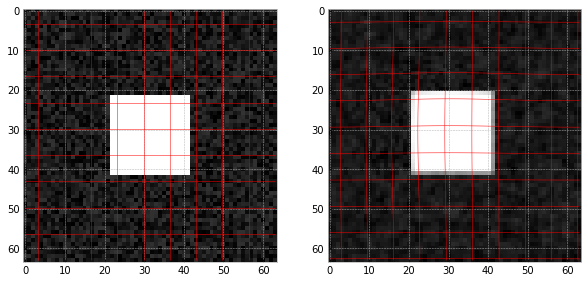

In [41]:
plt.figure(figsize=(10,5))
plt.subplot(121); show_warped_with_grid(h['recording'][0]['iW'], 
                                        h['recording'][0]['phiWarped'], 
                                        'Deformation (at iteration {})'.format(0))
plt.subplot(122); show_warped_with_grid(h['recording'][-1]['iW'], 
                                        h['recording'][-1]['phiWarped'], 
                                        'Deformation (at convergence)')

Additionally, lets show the energy terms over the optimization iterations ...

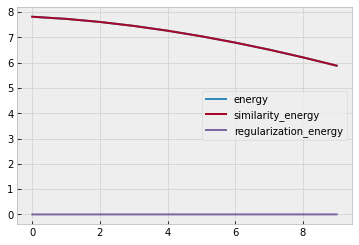

In [192]:
e_p, = plt.plot(h['energy'], label='energy')
s_p, = plt.plot(h['similarity_energy'], label='similarity_energy')
r_p, = plt.plot(h['regularization_energy'], label='regularization_energy')
plt.legend(handles=[e_p,s_p,r_p])
plt.show()

## Using mermaids visualization

In [44]:
"""
import torch
import mermaid.utils as utils
import mermaid.visualize_registration_results as vizreg

I_0 = torch.from_numpy(I0_syn)
I_1 = torch.from_numpy(I1_syn)
phi = si.get_map()
I_W = utils.compute_warped_image_multiNC(I_0, 
                                         phi, 
                                         spacing_syn, 
                                         spline_order=1)
vizreg.show_current_images(len(si.get_history()['energy']), 
                           I_0, 
                           I_1, 
                           I_W, 
                           phiWarped=phi)
"""

"\nimport torch\nimport mermaid.utils as utils\nimport mermaid.visualize_registration_results as vizreg\n\nI_0 = torch.from_numpy(I0_syn)\nI_1 = torch.from_numpy(I1_syn)\nphi = si.get_map()\nI_W = utils.compute_warped_image_multiNC(I_0, \n                                         phi, \n                                         spacing_syn, \n                                         spline_order=1)\nvizreg.show_current_images(len(si.get_history()['energy']), \n                           I_0, \n                           I_1, \n                           I_W, \n                           phiWarped=phi)\n"